# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu giá cà phê nội địa

Dữ liệu về giá cà phê được thu thập của tỉnh Đăk Lăk, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến hết năm 2023.
*   date*: ngày
*   price: giá cà phê

In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_den_2023.csv', encoding='ISO-8859-1')
df_coffee.tail()

,date,price
6203,12/27/2023,68000.0
6204,12/28/2023,68850.0
6205,12/29/2023,70000.0
6206,12/30/2023,68200.0
6207,12/31/2023,68200.0


In [ ]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6208 non-null   object 
 1   price   6208 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.1+ KB


In [ ]:
df_coffee['date'] = pd.to_datetime(df_coffee['date'])
df_coffee.set_index('date', inplace=True)

### Điền dữ liệu ngày còn thiếu

In [ ]:
df_coffee.shape

(6208, 1)

In [ ]:
idx = pd.date_range(df_coffee.index.min(), df_coffee.index.max())
df_coffee = df_coffee.reindex(idx)
df_coffee.fillna(method='ffill', inplace=True)
df_coffee.tail()

,price
2023-12-27,68000.0
2023-12-28,68850.0
2023-12-29,70000.0
2023-12-30,68200.0
2023-12-31,68200.0


In [ ]:
df_coffee.shape

(6208, 1)

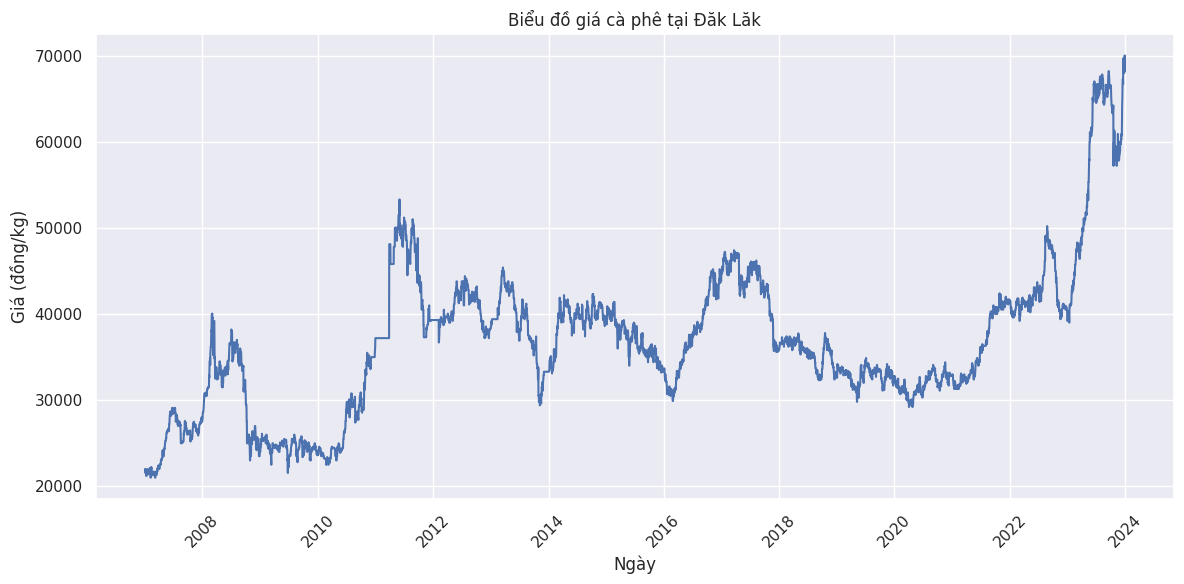

In [ ]:
plt.rcParams.update({'font.size': 32})
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# sns.set(style="darkgrid")
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')

# plt.title('Biểu đồ giá cà phê tại Đăk Lăk', fontsize=32)
# plt.xlabel('Ngày', fontsize=28)
# plt.ylabel('Giá (đồng/kg)', fontsize=28)
# plt.xticks(rotation=45, fontsize=24)
# plt.yticks(fontsize=24)
# plt.tight_layout()
# plt.show()

## Làm mịn dữ liệu

In [ ]:
df_coffee = df_coffee.rolling(window=30, min_periods=1).mean()

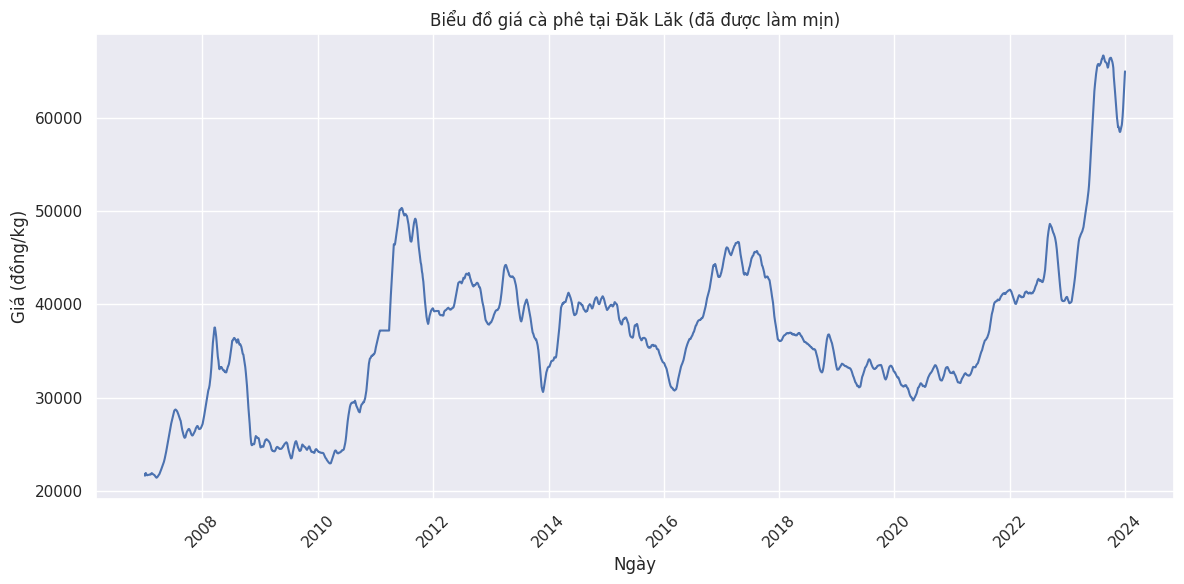

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk (đã được làm mịn)')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# sns.set(style="darkgrid")
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')

# plt.title('Biểu đồ giá cà phê tại Đăk Lăk (đã làm mịn)', fontsize=32)
# plt.xlabel('Ngày', fontsize=28)
# plt.ylabel('Giá (đồng/kg)', fontsize=28)
# plt.xticks(rotation=45, fontsize=24)
# plt.yticks(fontsize=24)
# plt.tight_layout()
# plt.show()

# Mô hình LSTM dự đoán đơn biến

Mạng LSTM (Long Short-Term Memory) là mạng nơ-ron hồi quy có khả năng xử lý chuỗi thời gian dài hạn với cấu trúc gồm ba cổng:
*   Cổng quên (f): xác định thông tin nào của trạng thái tạm thời cũ được lưu trữ hoặc loại bỏ bằng hàm sigmoid.
*   Cổng nhập (i): xác định thông tin được thêm vào trạng thái tạm thời bằng hàm sigmoid.
*   Cổng xuất (o): xác định thông tin được xuất làm đầu ra của mạng LSTM hàm sigmoid.
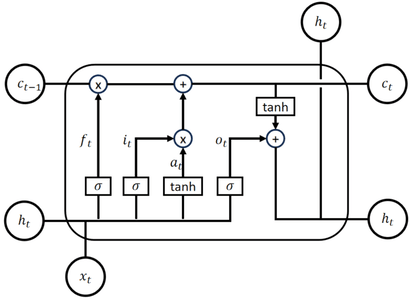

## Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(df_coffee['price'].values.reshape(-1, 1))

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_price, seq_length)

In [ ]:
X.shape, y.shape

((6178, 30, 1), (6178, 1))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (4942, 30, 1) (4942, 1)
Kích thước tập kiểm tra: (1236, 30, 1) (1236, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
78/78 [==============================] - 8s 56ms/step - loss: 0.0080
Epoch 2/50
78/78 [==============================] - 4s 55ms/step - loss: 5.4193e-04
Epoch 3/50
78/78 [==============================] - 6s 77ms/step - loss: 4.4919e-04
Epoch 4/50
78/78 [==============================] - 4s 57ms/step - loss: 3.9546e-04
Epoch 5/50
78/78 [==============================] - 4s 54ms/step - loss: 3.6176e-04
Epoch 6/50
78/78 [==============================] - 6s 74ms/step - loss: 3.2959e-04
Epoch 7/50
78/78 [==============================] - 4s 53ms/step - loss: 3.2605e-04
Epoch 8/50
78/78 [==============================] - 4s 57ms/step - loss: 3.2451e-04
Epoch 9/50
78/78 [==============================] - 6s 74ms/step - loss: 2.7945e-04
Epoch 10/50
78/78 [==============================] - 4s 54ms/step - loss: 3.0678e-04
Epoch 11/50
78/78 [==============================] - 5s 59ms/step - loss: 2.8333e-04
Epoch 12/50
78/78 [==============================] - 5s 65ms/step - loss: 2.54

## Dự đoán tập train

In [ ]:
train_predictions = model.predict(X_train)

155/155 [==============================] - 3s 15ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 163.86
Training MAPE: 0.36%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình LSTM)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Dự đoán tập test

In [ ]:
test_predictions = model.predict(X_test)

39/39 [==============================] - 1s 15ms/step


In [ ]:
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {train_mape:.2f}%')

Testing RMSE: 204.59
Testing MAPE: 0.36%


In [ ]:
dates = df_coffee.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình LSTM)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  163.86      0.36
1   Test  204.59      0.34


## Lưu mô hình



In [ ]:
# model.save('LSTM_gia_cafe.h5')